# Convolutional neural networks
The goal of this notebook is to perform binary classification over images using convolutional neural networks.

The goal of this notebook is to classify pictures of balls into two groups: 
- tennis balls 
- non tennis balls. 

To do so, we run a __convolutional neural network__ structured as:
#CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

The algorithm is trained over $(X_{train},Y_{train})$ to classify binarily in $C=2$ classes and is tested over $(X_{train},Y_{train})$.

In this notebook, we will 
* introduce the data loader and some utility functions
* build the model
* run the algorithm over the loaded picture sets

***



Let's import common libraries to manipulate arrays, images, Tensorflow.

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

Defining some global variables to import pictures: 

In [3]:
#################################################################
# DATASET VARIABLES
#################################################################
set_nb_pictures_train=13
set_nb_pictures_test=13
set_path="./dataset/"
set_path_train=set_path+"train/"
set_path_test=set_path+"test/"
set_train_cropped_path=set_path_train+"cropped/"
set_test_cropped_path=set_path_test+"cropped/"
set_train_raw_path=set_path_train+"raw/"
set_test_raw_path=set_path_test+"raw/"

### A1. Data loader
The data will be loaded using the load_dataset function, returning a list of $X_{train},Y_{train},X_{test},Y_{test}$

In [4]:
#################################################################
# DATA LOADING
#################################################################
def load_data():
    X_train=[]
    Y_train=[]
    X_test=[]
    Y_test=[]
    
    #read X_train
    for i in range(1,set_nb_pictures_train):
        src=set_train_cropped_path+str(i)+".jpg"
        X_train.append(np.array(Image.open(src)))
    #read X_test
    for i in range(1,set_nb_pictures_test):
        src=set_test_cropped_path+str(i)+".jpg"
        X_test.append(np.array(Image.open(src)))
        
    #read Y_train
    with open(set_path_train+"y.desc") as f:
        content=f.readlines()
        content = [x.strip() for x in content] 
        for line in content:
            sp=line.split(" ")
            Y_train.append(int(sp[1]))
    #read Y_test
    with open(set_path_test+"y.desc") as f:
        content=f.readlines()
        content = [x.strip() for x in content] 
        for line in content:
            sp=line.split(" ")
            Y_test.append(int(sp[1]))
    return X_train,Y_train,X_test,Y_test

### A2. Utils functions
These functions will help build the model. We create TensorFlow place holders, initialize weights and biases. We also have a function to convert $Y$ as a one hot vector and finally a batch generator.

In [63]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32,shape=(None,n_H0,n_W0,n_C0),name="X")
    Y = tf.placeholder(tf.float32,shape=(None,n_y),name="Y")
    return X, Y

def initialize_parameters():
    W1 = tf.get_variable("W1", [4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters


def convert_to_one_hot(Y,C):
    return np.eye(C)[np.asarray(Y).reshape(-1)].T

#################################################################
# BATCH SHUFFLE
#################################################################
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

***
## B. The model
### B1. Propagation functions
A classical softmax entropy cost is used for the classification. ReLU functions provide the output of the hidden layers.

In [64]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

def forward_propagation(X, parameters):
    #CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 =  tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 =  tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 2,activation_fn=None)
    return Z3

This is the main function that performs the computation. We create a TensorFlow session to run the optimizer over the mini-batches.

In [71]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
   
    ops.reset_default_graph()                         # we want to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

## C. Run
### C1. Load data
We now have all the ingredients to run the optimization. Let's load the data, format it and run the model on it.

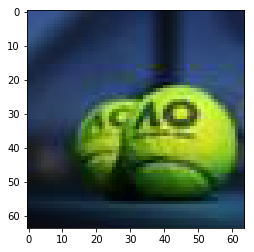

In [76]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_data()
C=2
plt.imshow(X_train_orig[0])

### C2. Format data

In [73]:
X_train_orig=np.asarray(X_train_orig)
X_train=X_train_orig/255

X_test_orig=np.asarray(X_test_orig)
X_test=X_test_orig/255

Y_train=convert_to_one_hot(Y_train_orig,C).T
Y_test=convert_to_one_hot(Y_test_orig,C).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: "+str(X_train.shape))
print("X_test shape: "+str(X_test.shape))
print("Y_train shape: "+str(Y_train.shape))
print("Y_test shape: "+str(Y_test.shape))


number of training examples = 12
number of test examples = 12
X_train shape: (12, 64, 64, 3)
X_test shape: (12, 64, 64, 3)
Y_train shape: (12, 2)
Y_test shape: (12, 2)


### C3. Launch

Cost after epoch 0: 1.616842
Cost after epoch 5: 1.879732
Cost after epoch 10: 1.476278
Cost after epoch 15: 1.727838
Cost after epoch 20: 1.691925
Cost after epoch 25: 1.487954
Cost after epoch 30: 1.320507
Cost after epoch 35: 1.219382
Cost after epoch 40: 1.291097
Cost after epoch 45: 1.165882
Cost after epoch 50: 1.219008
Cost after epoch 55: 1.094468
Cost after epoch 60: 1.031850
Cost after epoch 65: 0.957947
Cost after epoch 70: 1.031191
Cost after epoch 75: 1.062027
Cost after epoch 80: 1.049569
Cost after epoch 85: 0.810665
Cost after epoch 90: 1.010026
Cost after epoch 95: 0.769846
Cost after epoch 100: 0.792402
Cost after epoch 105: 0.757602
Cost after epoch 110: 0.974157
Cost after epoch 115: 0.947910
Cost after epoch 120: 0.680146
Cost after epoch 125: 0.646303
Cost after epoch 130: 0.620759
Cost after epoch 135: 0.634760
Cost after epoch 140: 0.941896
Cost after epoch 145: 0.641601
Cost after epoch 150: 0.625923
Cost after epoch 155: 0.861744
Cost after epoch 160: 0.573993

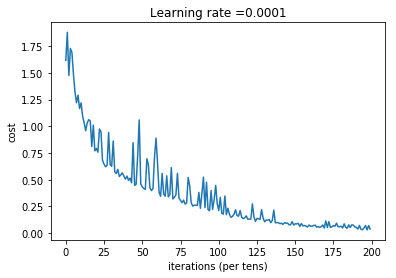

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.916667


In [75]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,0.0001,1000,10,True)

The algorithms reaches an accuracy of 91% over the test set.